In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel('mmc4.xlsx', sheet_name='Glycoprotien_Tumor_vs_NAT')
df.head(3)

,Gene,log2FC,adjusted_p,"""-LOG10(adjusted_p)""",Cellular_Location,DIA_TumorvsNAT_log2FC,DIA_TumorvsNAT_adjusted_p
0,A1BG,0.504107,0.000027,4.566462,Secreted(blood),1.525133,0.000147
1,A2M,0.358355,0.013139,1.881433,Secreted(blood),0.526600,0.103182
2,A2ML1,0.436528,0.001063,2.973650,Other,NaN,NaN


In [4]:
df_subset = df[["Gene", "log2FC", "adjusted_p", "\"-LOG10(adjusted_p)\"", "Cellular_Location"]].copy()
# log2FC >1: >2X Up, log2FC <-1: >2X Down, 0 < log2FC < 1: Up, -1 < log2FC < 0: Down, NS
df_subset["Category"] = pd.cut(df_subset["log2FC"], 
                             bins=[-float('inf'), -1, 0, 1, float('inf')],
                             labels=[">2X Down", "Down", "Up", ">2X Up"])
# Set Category as NS if adjusted_p < 0.01
df_subset["Category"] = df_subset["Category"].cat.add_categories("NS")
df_subset.loc[df_subset["adjusted_p"] >= 0.01, "Category"] = "NS"
# How many secreted proteins are there in each category?
# df_subset[df_subset["Cellular_Location"] == "Secreted"].groupby("Category").size()
df_subset.groupby("Cellular_Location").count()


,Gene,log2FC,adjusted_p,"""-LOG10(adjusted_p)""",Category
Cellular_Location,,,,,
Membrane,318,318,318,318,318
Other,207,207,207,207,207
Secreted,179,179,179,179,179
Secreted(blood),184,184,184,184,184


18


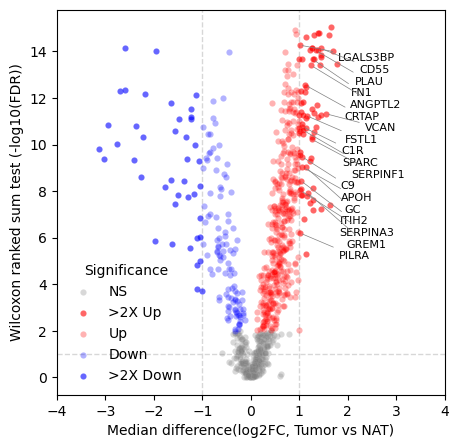

In [18]:
plt.figure(figsize=(5,5))
cat_settings = {
    "NS": {"color": "gray", "alpha": 0.3},
    ">2X Up": {"color": "red", "alpha": 0.6},
    "Up": {"color": "red", "alpha": 0.3},
    "Down": {"color": "blue", "alpha": 0.3},
    ">2X Down": {"color": "blue", "alpha": 0.6},
}
cnt =0
# 카테고리별로 scatterplot 개별 호출
for cat, props in cat_settings.items():
    subset = df_subset[df_subset["Category"] == cat]
    sns.scatterplot(
        data=subset,
        x='log2FC',
        y='"-LOG10(adjusted_p)"',
        color=props["color"],
        label=cat,
        alpha=props["alpha"],
        s=20,
        edgecolor="white",
        linewidth=0.1
    )
    if cat == ">2X Up":
        secreted_subset = subset[subset["Cellular_Location"] == "Secreted(blood)"]
        # Sort by adjusted_p
        secreted_subset = secreted_subset.sort_values(by="adjusted_p", ascending=True)
        
        for _, row in secreted_subset.iterrows():
            cnt+=1
            plt.annotate(
                text=row["Gene"],
                xy=(row["log2FC"], row['"-LOG10(adjusted_p)"']),
                # xytext=(row["log2FC"] + 1, row['"-LOG10(adjusted_p)"'] + 0.5),
                xytext=(row["log2FC"] + 0.8, 14-cnt *0.5),
                textcoords='data',
                fontsize=8,
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
                horizontalalignment='left',
                verticalalignment='bottom'
            )
print(cnt)

plt.legend(title="Category")
plt.xlim(-4,4)
plt.xlabel("Median difference(log2FC, Tumor vs NAT)")
plt.ylabel("Wilcoxon ranked sum test (-log10(FDR))")
plt.legend(frameon = False, title = "Significance")

# Draw line
plt.axhline(y=1, color='lightgray', linestyle='--', linewidth=1, alpha = 0.9, zorder = 0 )
plt.axvline(x=1, color='lightgray', linestyle='--', linewidth=1, alpha = 0.9, zorder = 0 )
plt.axvline(x=-1, color='lightgray', linestyle='--', linewidth=1, alpha = 0.9, zorder = 0 )
